In [1]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(20200129)

In [2]:
def simulations(pi_1, mu_1, mu_0, dim, sigma_1, sigma_0, N):
    """
   generate similated data points

         X, y = simulations(pi, mu_1, mu_0, dim, sigma_1, sigma_0, N = 1000)

     Inputs:
             pi_1: prior probability for Y = 1
             mu_1, mu_0:   means for X|Y=1 and X|Y=0
             dim:   dimension of the feature space of X
             sigma_1, sigma_0: standard deviations for X|Y=1 and X|Y=0
             N: number of data points

     Outputs:
            X: data points with features
            y: classification results
    """ 
    # generate y from Bernolli(pi) as a vector with N entries
    y = np.random.binomial(1, pi_1, N)
    X = np.zeros([N, dim]) # initialize X
    num_1 = np.sum(y == 1)
    num_0 = np.sum(y == 0)
    X[y == 1] = np.random.multivariate_normal(mean = mu_1, cov = sigma_1, size = num_1)
    X[y == 0] = np.random.multivariate_normal(mean = mu_0, cov = sigma_0, size = num_0)
    return X, y

In [3]:
# import baseline models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTE  
from imblearn.pipeline import Pipeline as Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import (GridSearchCV,StratifiedKFold)
# scale and split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [5]:
def Bayes_proba(x, pi_1, mu_0, mu_1, Sigma):
    tmp = np.exp((mu_0[:,None] - mu_1[:,None]).T @ np.linalg.solve(Sigma, (x.T - (mu_0[:,None] + mu_1[:,None])/2)))
    return (pi_1/(pi_1 + (1 - pi_1) * tmp))[0,:]

In [9]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, log_loss, recall_score, precision_recall_curve, auc
from sklearn.metrics import roc_curve, accuracy_score
seed=7
models = [] # Here I will append all the algorithms that I will use. Each one will run in all the created datasets.
models.append(('LR', LogisticRegression())) 
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))

In [47]:
def simulation_results(pi_1, mu, dim, N, N_test):
    """
   generate similated data points, then get socres and plots

         simulation_results(dim = 10, mu = 1)

     Inputs:
             pi_1: prior probability for Y = 1
             mu:   means for X|Y=1 and X|Y=0 are (mu, 0, ...,0) and (-mu, 0, ...,0) respectively
             dim:   dimension of the feature space of X
             N: number of training data points
             N_test: number of test points

     Outputs:
            X: data points with features
            y: classification results
    """ 
    # initialization
    np.random.seed(20200129)
    mu_1 = np.zeros(dim,)
    mu_1[0] = mu
    mu_0 = np.zeros(dim,)
    mu_0[0] = -mu
    sigma_1 = np.identity(dim)
    sigma_0 = np.identity(dim)
    X_train, y_train = simulations(pi_1, mu_1, mu_0, dim, sigma_1, sigma_0, N)
    X_test, y_test = simulations(pi_1, mu_1, mu_0, dim, sigma_1, sigma_0, N_test)
    # class distribution
    train_ratio = y_train.sum()/len(y_train)
    test_ratio = y_test.sum()/len(y_test)
    print('Positive ratios for pi_1 =',pi_1, ', mu =', mu,', dim =',dim,' are',train_ratio,
          'and',test_ratio,'for training and testing respectively.')
    """
    # scale and fit
    scaler.fit(X)
    X_scaled = scaler.transform(X)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=444, stratify=y)
    """
    # compare different classifiers
    results_accuracy=[]
    results_auroc=[]
    results_average_precision=[]
    results_neg_log_loss=[]
    results_f1 = []
    results_recall =[]
    names=[]
    fpr_full = []
    tpr_full = []
    thresholds_roc_full = []
    precision_full = []
    recall_full = []
    thresholds_prc_full = []
    measures = ['AUROC','AUPRC','accuracy','log loss','F1']
    scores_table = np.zeros([7,5])
    roc_cut = np.zeros([8,]).astype(int) # cut points for fpr, tpr, thresholds for ROC curve of each model
    prc_cut = np.zeros([8,]).astype(int) # cut points for precision, recall, thresholds for PRC curve of each model
    i = 0 # looping index
    for name, model in models:
            y_pred_proba = model.fit(X_train, y_train).predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
            fpr_full = np.concatenate((fpr_full, fpr))
            tpr_full = np.concatenate((tpr_full, tpr))
            thresholds_roc_full = np.concatenate((thresholds_roc_full, thresholds))
            roc_cut[i + 1] = roc_cut[i] + fpr.shape[0]
            #Area under ROC curve
            auroc = roc_auc_score(y_test,y_pred_proba)
            precision, recall, thresholds = precision_recall_curve(y_test,y_pred_proba)
            precision_full = np.concatenate((precision_full, precision))
            recall_full = np.concatenate((recall_full, recall))
            thresholds_prc_full = np.concatenate((thresholds_prc_full, thresholds))
            prc_cut[i + 1] = prc_cut[i] + recall.shape[0]
            # area under PRC curve
            auprc = auc(recall, precision)
            
            accuracy = accuracy_score(y_test, model.predict(X_test))
            average_precision = average_precision_score(y_test, model.predict(X_test))
            f1 = f1_score(y_test, model.predict(X_test))
            log_loss_score = log_loss(y_test, model.predict(X_test))
            recall = recall_score(y_test, model.predict(X_test))
            names.append(name)


            # report of scores
            scores_table[i, 0] = auroc
            scores_table[i, 1] = auprc
            scores_table[i, 2] = accuracy
            scores_table[i, 3] = log_loss_score
            scores_table[i, 4] = f1

            print(name,': AUROC = {:.3f}, AUPRC = {:.3f}, '.format(auroc,auprc),
                  '. \nAccuracy = {:.3f}, log loss = {:.3f},'.format(accuracy, log_loss_score))
            print ("--"*30)
            i = i + 1
    
    # Bayes classifier
    y_pred_prob_Bayes = Bayes_proba(X_test, pi_1, mu_0, mu_1, Sigma = sigma_1)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    #Area under ROC curve
    auroc = roc_auc_score(y_test,y_pred_prob_Bayes)
    
    precision, recall, thresholds = precision_recall_curve(y_test,y_pred_prob_Bayes)
    auprc = auc(recall, precision)
    print('Bayes classifier has AUROC = {:.3f},and AUPRC = {:.3f}.'.format(auroc, auprc))
    scores_table[5, 0] = auroc # Bayes
    scores_table[5, 1] = auprc # Bayes
    scores_table[6, 0] = 0.5 # random guess
    scores_table[6, 1] = test_ratio # random guess   
    #plot ROC
    plt.plot([0,1],[0,1],'k--')
    plt.plot(fpr,tpr)
    for i in range(7):
        plt.plot(fpr_full[roc_cut[i]:roc_cut[i + 1]],tpr_full[roc_cut[i]:roc_cut[i + 1]], label=name)
    plt.xlabel('fpr')
    plt.ylabel('tpr')
    title_name = 'ROC curve for $\pi_1$=' + str(pi_1) + ',$\mu$=' + str(mu) + ',N=' + str(N) + ',dimension = ' + str(dim)
    plt.title(title_name)
    plt.legend(['random guess','Bayes','LR', 'LDA','KNN','NB','RF'])
    save_name = '10pi' + str(int(10*pi_1)) + '_10mu' + str(int(10*mu)) + '_N' + str(N) + '_dim' + str(dim) + '_simulation_ROC_curve.png'
    plt.savefig(save_name)
    plt.show()

    # plot PRC
    plt.axhline(y=test_ratio, xmin=0, xmax=1,color='k', linestyle = '--')
    plt.plot(recall,precision, label=name)
    for i in range(7):
        plt.plot(recall_full[prc_cut[i]:prc_cut[i + 1]],precision_full[prc_cut[i]:prc_cut[i + 1]], label=name)
    plt.xlabel('recall')
    plt.ylabel('precision')
    title_name = 'Precision-Recall curve for $\pi_1$=' + str(pi_1) + ',$\mu$=' + str(mu) + ',N=' + str(N) + ',dimension = ' + str(dim)
    plt.title(title_name)
    plt.legend(['random guess','Bayes','LR', 'LDA','KNN','NB','RF'])
    save_name = '10pi' + str(int(10*pi_1)) + '_10mu' + str(int(10*mu)) + '_N' + str(N) + '_dim' + str(dim) + '_simulation_PRcurve.png'
    plt.savefig(save_name)
    plt.show()
    
    for i in range(5):
        print('The best model measured by ',measures[i],'is ',names[np.argmax(scores_table[:5,i])]) 
    print ("--"*30)
    print ("--"*30)
    csv_name ='10pi' + str(int(10*pi_1)) + '_10mu' + str(int(10*mu)) + '_N' + str(N) + '_dim' + str(dim) + '.csv'
    np.savetxt(csv_name, scores_table, delimiter=",")

Positive ratios for pi_1 = 0.5 , mu = 1 , dim = 5  are 0.52 and 0.492 for training and testing respectively.
LR : AUROC = 0.919, AUPRC = 0.917,  . 
Accuracy = 0.834, log loss = 5.733,
------------------------------------------------------------
LDA : AUROC = 0.921, AUPRC = 0.918,  . 
Accuracy = 0.834, log loss = 5.734,
------------------------------------------------------------
KNN : AUROC = 0.899, AUPRC = 0.897,  . 
Accuracy = 0.830, log loss = 5.872,
------------------------------------------------------------
NB : AUROC = 0.921, AUPRC = 0.915,  . 
Accuracy = 0.835, log loss = 5.699,
------------------------------------------------------------
RF : AUROC = 0.881, AUPRC = 0.887,  . 
Accuracy = 0.811, log loss = 6.528,
------------------------------------------------------------
Bayes classifier has AUROC = 0.929,and AUPRC = 0.927.


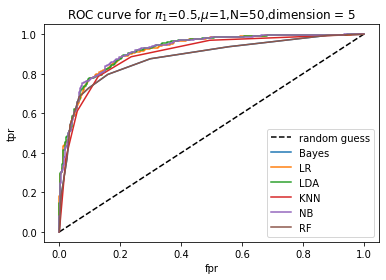

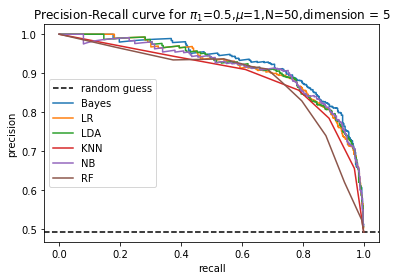

The best model measured by  AUROC is  NB
The best model measured by  AUPRC is  LDA
The best model measured by  accuracy is  NB
The best model measured by  log loss is  RF
The best model measured by  F1 is  LDA
------------------------------------------------------------
------------------------------------------------------------


In [48]:
# can tune parameters here and see different results
simulation_results(pi_1 = 0.5, mu = 1, dim = 5, N = 50, N_test = 1000)

Positive ratios for pi_1 = 0.5 , mu = 0.5 , dim = 5  are 0.52 and 0.492 for training and testing respectively.
LR : AUROC = 0.755, AUPRC = 0.741,  . 
Accuracy = 0.696, log loss = 10.500,
------------------------------------------------------------
LDA : AUROC = 0.755, AUPRC = 0.741,  . 
Accuracy = 0.697, log loss = 10.465,
------------------------------------------------------------
KNN : AUROC = 0.735, AUPRC = 0.732,  . 
Accuracy = 0.689, log loss = 10.742,
------------------------------------------------------------
NB : AUROC = 0.755, AUPRC = 0.711,  . 
Accuracy = 0.707, log loss = 10.120,
------------------------------------------------------------
RF : AUROC = 0.688, AUPRC = 0.668,  . 
Accuracy = 0.656, log loss = 11.881,
------------------------------------------------------------
Bayes classifier has AUROC = 0.777,and AUPRC = 0.767.


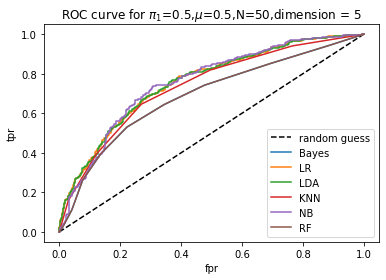

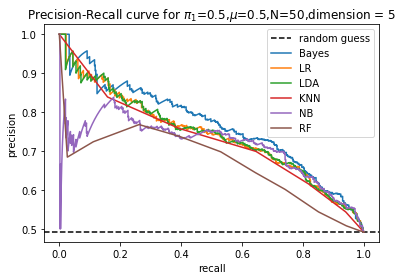

The best model measured by  AUROC is  LDA
The best model measured by  AUPRC is  LR
The best model measured by  accuracy is  NB
The best model measured by  log loss is  RF
The best model measured by  F1 is  NB
------------------------------------------------------------
------------------------------------------------------------


In [49]:
simulation_results(pi_1 = 0.5, mu = 0.5, dim = 5, N = 50, N_test = 1000)

Positive ratios for pi_1 = 0.5 , mu = 0.5 , dim = 5  are 0.52 and 0.492 for training and testing respectively.
LR : AUROC = 0.755, AUPRC = 0.741,  . 
Accuracy = 0.696, log loss = 10.500,
------------------------------------------------------------
LDA : AUROC = 0.755, AUPRC = 0.741,  . 
Accuracy = 0.697, log loss = 10.465,
------------------------------------------------------------
KNN : AUROC = 0.735, AUPRC = 0.732,  . 
Accuracy = 0.689, log loss = 10.742,
------------------------------------------------------------
NB : AUROC = 0.755, AUPRC = 0.711,  . 
Accuracy = 0.707, log loss = 10.120,
------------------------------------------------------------
RF : AUROC = 0.688, AUPRC = 0.668,  . 
Accuracy = 0.656, log loss = 11.881,
------------------------------------------------------------
Bayes classifier has AUROC = 0.777,and AUPRC = 0.767.


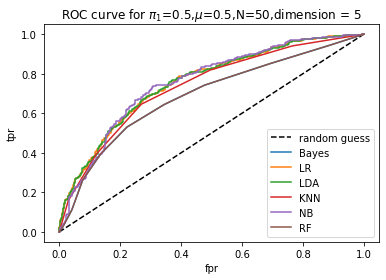

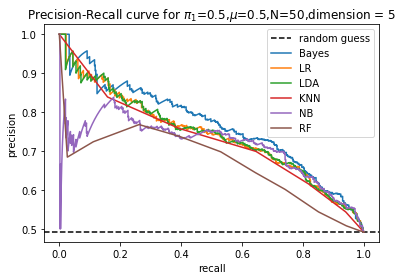

The best model measured by  AUROC is  LDA
The best model measured by  AUPRC is  LR
The best model measured by  accuracy is  NB
The best model measured by  log loss is  RF
The best model measured by  F1 is  NB
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.5 , mu = 0.5 , dim = 5  are 0.492 and 0.488 for training and testing respectively.
LR : AUROC = 0.759, AUPRC = 0.739,  . 
Accuracy = 0.706, log loss = 10.155,
------------------------------------------------------------
LDA : AUROC = 0.758, AUPRC = 0.739,  . 
Accuracy = 0.701, log loss = 10.327,
------------------------------------------------------------
KNN : AUROC = 0.662, AUPRC = 0.658,  . 
Accuracy = 0.616, log loss = 13.263,
------------------------------------------------------------
NB : AUROC = 0.756, AUPRC = 0.733,  . 
Accuracy = 0.706, log loss = 10.155,
------------------------------------------------------------
RF : AU

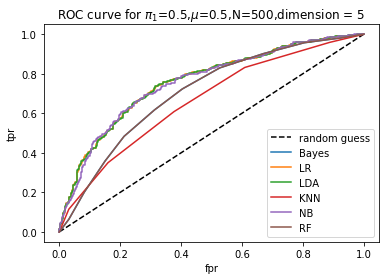

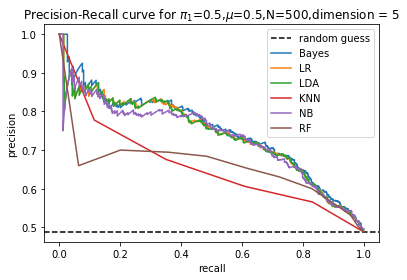

The best model measured by  AUROC is  LR
The best model measured by  AUPRC is  LR
The best model measured by  accuracy is  LR
The best model measured by  log loss is  KNN
The best model measured by  F1 is  NB
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.5 , mu = 0.5 , dim = 5  are 0.5014 and 0.528 for training and testing respectively.
LR : AUROC = 0.768, AUPRC = 0.783,  . 
Accuracy = 0.699, log loss = 10.396,
------------------------------------------------------------
LDA : AUROC = 0.768, AUPRC = 0.783,  . 
Accuracy = 0.700, log loss = 10.362,
------------------------------------------------------------
KNN : AUROC = 0.693, AUPRC = 0.726,  . 
Accuracy = 0.639, log loss = 12.469,
------------------------------------------------------------
NB : AUROC = 0.768, AUPRC = 0.785,  . 
Accuracy = 0.700, log loss = 10.362,
------------------------------------------------------------
RF : A

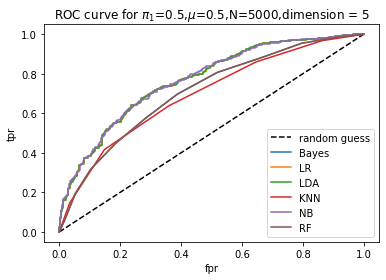

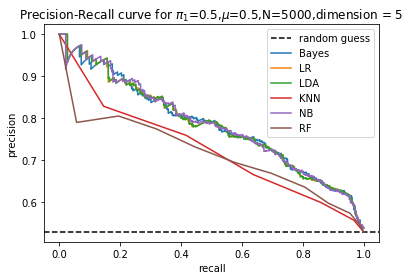

The best model measured by  AUROC is  NB
The best model measured by  AUPRC is  NB
The best model measured by  accuracy is  LDA
The best model measured by  log loss is  KNN
The best model measured by  F1 is  LDA
------------------------------------------------------------
------------------------------------------------------------


In [50]:
# can tune parameters here and see different results
for pi_1 in [0.5]:
    for N_train in [50, 500, 5000]:
        simulation_results(pi_1, mu = 0.5, dim = 5, N = N_train, N_test = 1000)

Positive ratios for pi_1 = 0.1 , mu = 0.5 , dim = 5  are 0.06 and 0.098 for training and testing respectively.
LR : AUROC = 0.675, AUPRC = 0.167,  . 
Accuracy = 0.889, log loss = 3.834,
------------------------------------------------------------
LDA : AUROC = 0.655, AUPRC = 0.158,  . 
Accuracy = 0.879, log loss = 4.179,
------------------------------------------------------------
KNN : AUROC = 0.595, AUPRC = 0.175,  . 
Accuracy = 0.902, log loss = 3.385,
------------------------------------------------------------
NB : AUROC = 0.539, AUPRC = 0.114,  . 
Accuracy = 0.885, log loss = 3.972,
------------------------------------------------------------
RF : AUROC = 0.592, AUPRC = 0.140,  . 
Accuracy = 0.900, log loss = 3.454,
------------------------------------------------------------
Bayes classifier has AUROC = 0.750,and AUPRC = 0.276.


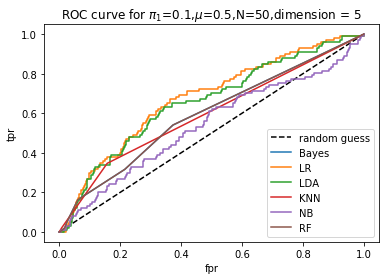

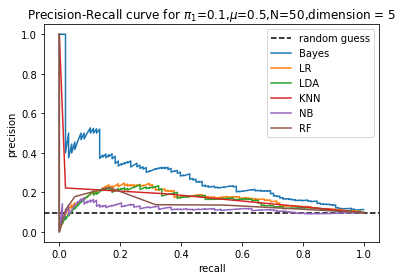

The best model measured by  AUROC is  LR
The best model measured by  AUPRC is  KNN
The best model measured by  accuracy is  KNN
The best model measured by  log loss is  LDA
The best model measured by  F1 is  NB
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.2 , mu = 0.5 , dim = 5  are 0.2 and 0.193 for training and testing respectively.
LR : AUROC = 0.708, AUPRC = 0.376,  . 
Accuracy = 0.786, log loss = 7.391,
------------------------------------------------------------
LDA : AUROC = 0.705, AUPRC = 0.367,  . 
Accuracy = 0.785, log loss = 7.426,
------------------------------------------------------------
KNN : AUROC = 0.684, AUPRC = 0.356,  . 
Accuracy = 0.801, log loss = 6.873,
------------------------------------------------------------
NB : AUROC = 0.695, AUPRC = 0.334,  . 
Accuracy = 0.787, log loss = 7.357,
------------------------------------------------------------
RF : AUROC 

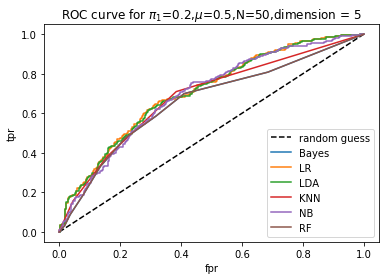

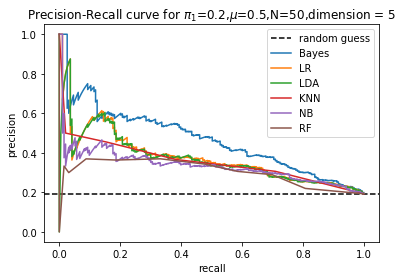

The best model measured by  AUROC is  LR
The best model measured by  AUPRC is  LR
The best model measured by  accuracy is  KNN
The best model measured by  log loss is  RF
The best model measured by  F1 is  LR
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.3 , mu = 0.5 , dim = 5  are 0.34 and 0.282 for training and testing respectively.
LR : AUROC = 0.735, AUPRC = 0.528,  . 
Accuracy = 0.734, log loss = 9.187,
------------------------------------------------------------
LDA : AUROC = 0.735, AUPRC = 0.530,  . 
Accuracy = 0.735, log loss = 9.153,
------------------------------------------------------------
KNN : AUROC = 0.727, AUPRC = 0.521,  . 
Accuracy = 0.743, log loss = 8.877,
------------------------------------------------------------
NB : AUROC = 0.737, AUPRC = 0.488,  . 
Accuracy = 0.714, log loss = 9.878,
------------------------------------------------------------
RF : AUROC =

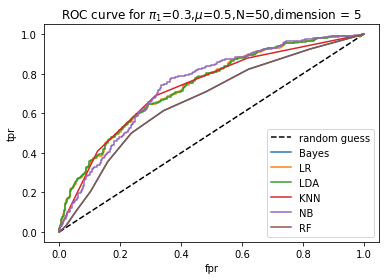

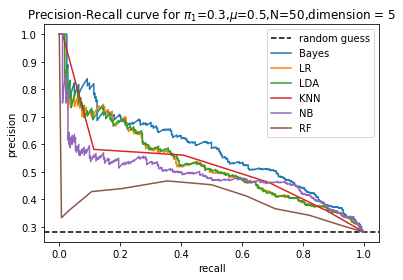

The best model measured by  AUROC is  NB
The best model measured by  AUPRC is  LDA
The best model measured by  accuracy is  KNN
The best model measured by  log loss is  RF
The best model measured by  F1 is  LR
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.4 , mu = 0.5 , dim = 5  are 0.46 and 0.393 for training and testing respectively.
LR : AUROC = 0.746, AUPRC = 0.649,  . 
Accuracy = 0.696, log loss = 10.500,
------------------------------------------------------------
LDA : AUROC = 0.751, AUPRC = 0.654,  . 
Accuracy = 0.700, log loss = 10.362,
------------------------------------------------------------
KNN : AUROC = 0.735, AUPRC = 0.630,  . 
Accuracy = 0.700, log loss = 10.362,
------------------------------------------------------------
NB : AUROC = 0.755, AUPRC = 0.633,  . 
Accuracy = 0.701, log loss = 10.327,
------------------------------------------------------------
RF : AU

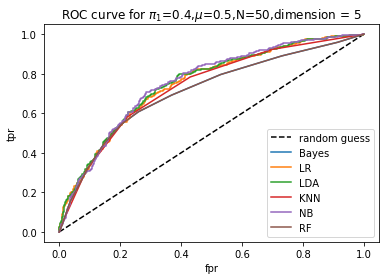

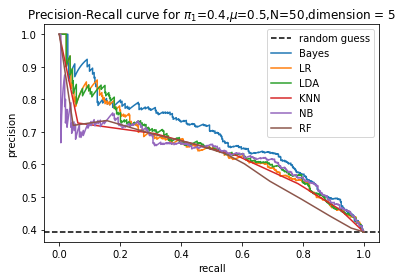

The best model measured by  AUROC is  NB
The best model measured by  AUPRC is  LDA
The best model measured by  accuracy is  NB
The best model measured by  log loss is  LR
The best model measured by  F1 is  LDA
------------------------------------------------------------
------------------------------------------------------------
Positive ratios for pi_1 = 0.5 , mu = 0.5 , dim = 5  are 0.52 and 0.492 for training and testing respectively.
LR : AUROC = 0.755, AUPRC = 0.741,  . 
Accuracy = 0.696, log loss = 10.500,
------------------------------------------------------------
LDA : AUROC = 0.755, AUPRC = 0.741,  . 
Accuracy = 0.697, log loss = 10.465,
------------------------------------------------------------
KNN : AUROC = 0.735, AUPRC = 0.732,  . 
Accuracy = 0.689, log loss = 10.742,
------------------------------------------------------------
NB : AUROC = 0.755, AUPRC = 0.711,  . 
Accuracy = 0.707, log loss = 10.120,
------------------------------------------------------------
RF : AU

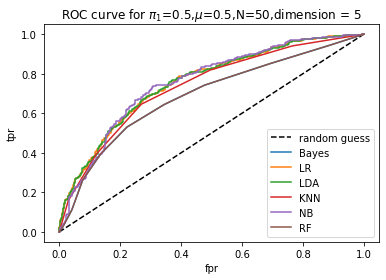

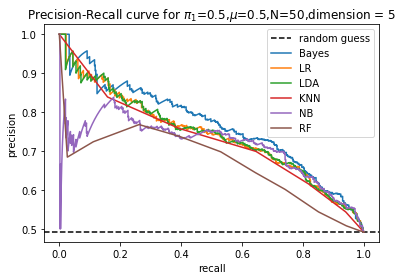

The best model measured by  AUROC is  LDA
The best model measured by  AUPRC is  LR
The best model measured by  accuracy is  NB
The best model measured by  log loss is  RF
The best model measured by  F1 is  NB
------------------------------------------------------------
------------------------------------------------------------


In [51]:
for pi_1 in [0.1,0.2,0.3,0.4,0.5]:
    for N_train in [50]:
        simulation_results(pi_1, mu = 0.5, dim = 5, N = N_train, N_test = 1000)